# ELG7186 - Fall 2022 - Assignment 3
## Due: <strong>Wednesday Nov. 23<sup>st</sup> 2022 -- 11:59pm</strong>

In this assignment, you will apply your knowledge of CNNs we want to estimate the growth stage of weeds using the number of leaves of the plant. The more leaves, the more the weed has grown.

The purpose of this assignment is to gain experience building and training neural networks. You will gain:
- More experience training CNNs
- Experience with problem reformulation
- Experience with techniques for improving results (Regularization, Data Augmentation)

You must use Keras with the Tensorflow backend, i.e., the package tensorflow.keras. For this assignment, you may use other tensorflow packages and scikit-learn, scikit-image or pandas but not other deep learning frameworks, e.g., pytorch, mxnet etc.

### Submission Details
Submit your Jupyter notebook .ipynb file using Brightspace. Do not include any other files or images as they will not be reviewed.
<p>
<strong>Make certain that you run all the cells in the notebook you submit</strong> or you will loose marks.
</p>
<ul>
<li>You can submit multiple times, but only the most recent submission will be saved</li>
<li>Do not wait until the last minute to submit in case you have an unexpected issue</li>
<li>Review the late policy in the syllabus</li>
<li><strong>You must submit your own work</strong> and abide by the University of Ottawa policy on plagiarism and fraud</li>
</ul>


### DO NOT submit any images from the dataset

## Part 0. Data Preparation

The data for this assignment are plant images at different resolutions captured with a variety of cameras. There are images showing plants with approximatelty 1,2,3,4 and 6 leafs. The images are part of a Leaf counting dataset by Teimouri et al. [1] which can be downloaded from the Aarhus University, Denmark:

<a href="https://vision.eng.au.dk/leaf-counting-dataset/">Leaf counting dataset</a> (Required files are posted on Brightspace)

However, you must work with the subset of images posted on BrightSpace as training.zip and testing.zip. There are 200 images for each of the 5 classes. As Figure 1 shows, there is a great variety of plants and image conditions. The dataset is split into a training and a testing set where there are 180 images per class for training and validation; and 20 images for testing.




In this section:
<ul>
<li>Download the dataset as described above</li>
<li>Use the splits provided in the Brightspace files</li>
<li>Visualize five images from the dataset.</li>
</ul>


## Import libraries

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import torch
import numpy as np
import random
import os
photo_size=128

## Set global random state for the notebook

In [2]:
def set_seed(seed=42):
    # Set a fixed value for python
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    # Set a fixed value for torch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for tensorflow
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    tf.random.set_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    print(f"Random seed set as {seed}")

seed=96
batch_size=64
set_seed(seed)

Random seed set as 96


## Visualize five images from the dataset from each class

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


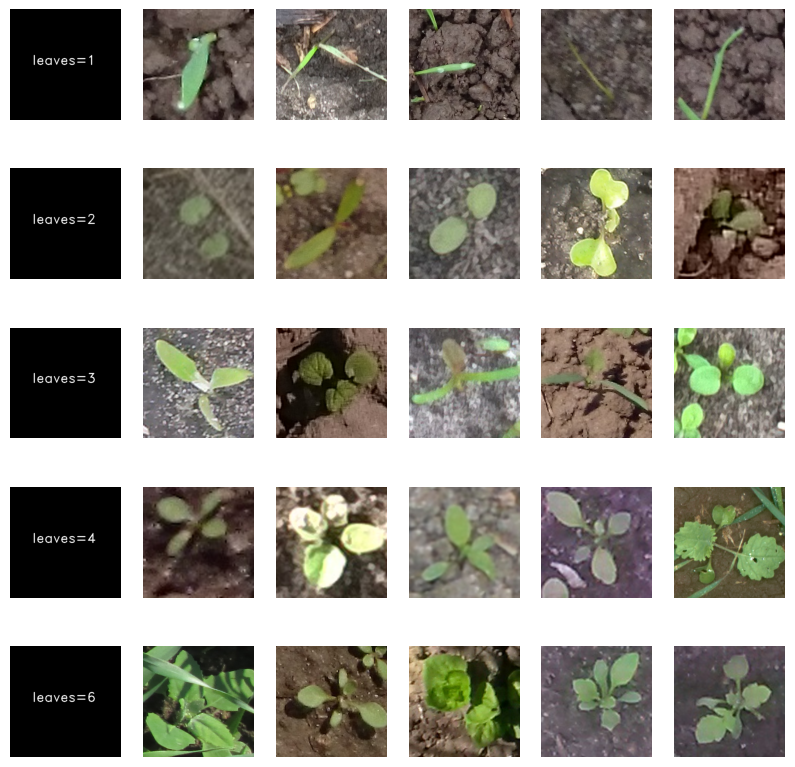

In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
# Prepare your dataset here
training_dir='training'
testing_dir='testing'
vis_images=[]
n_image_vis=5
for folder in os.listdir(training_dir):
    inner_path=os.path.join(training_dir,folder)
    samples=random.sample(os.listdir(inner_path),k=n_image_vis)
    name_image=np.zeros((500,500,3))
    r,g,b = cv2.split(name_image)
    img_bgr = cv2.merge([b,g,r])
    cv2.putText(img_bgr,text=f'leaves={folder}',org=(100,250),fontFace=cv2.QT_FONT_NORMAL,fontScale=2,color=(255,255,255),thickness=2)
    vis_images.append(img_bgr)
    for image in samples:
        img=Image.open(os.path.join(inner_path,image))
        img=img.resize((500,500))
        vis_images.append(img)
n_row,n_col=(len(os.listdir(training_dir)),n_image_vis+1)
_, axs = plt.subplots(n_row, n_col, figsize=(10, 10))
axs = axs.flatten()
for img, ax in zip(vis_images, axs):
    ax.imshow(img)
    ax.grid(False)
    ax.axis(False)


## Load the dataset from the directory using keras preprocessing utils

In [4]:
train_dataset_classification = tf.keras.preprocessing.image_dataset_from_directory(
    directory=training_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed,
    subset='training',
    validation_split=0.2
)
validation_dataset_classification = tf.keras.preprocessing.image_dataset_from_directory(
    directory=training_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed,
    subset='validation',
    validation_split=0.2
)
test_dataset_classification = tf.keras.preprocessing.image_dataset_from_directory(
    directory=testing_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed
)

Found 900 files belonging to 5 classes.
Using 720 files for training.
Found 900 files belonging to 5 classes.
Using 180 files for validation.
Found 100 files belonging to 5 classes.


## Data normalization

In [5]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_dataset_classification = train_dataset_classification.map(process)
test_dataset_classification = test_dataset_classification.map(process)

## Part 1a. Transfer Learning - Classification Network (3 Marks)
For this assignment, you are asked to use the Keras implementation of VGG-16 as a starting point. 

Using the first 2 blocks of VGG-16 add extra Keras layers to create your own version of a CNN network for the classification of the images according to the number of leaves in the plant images. Note that there will be 5 classes. The last layer from VGG-16 will be block2 pool and you are allowed to add no more than five fully connected or convolutional layers to the network including the final output layer. 

- You can use as many pooling, flattening, 1 × 1 convolution layers, etc. as you wish but do not use any regularization.
- Train this simple network on the training set while monitoring convergence on the validation set.
- As input to the model use images of size no larger than 128×128.

Note, it is highly recommended to use even smaller input images to try things out. You are not expected to fine-tune the initial VGG layers.

When your classifier is working:
- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.


In [14]:
# Write your code here
from keras.applications.vgg16 import VGG16
from keras import Model
from keras import layers
base_vgg_model = VGG16(input_shape = (photo_size, photo_size, 3), include_top = False, weights ='imagenet')
base_vgg_model.trainable=False
x = layers.Conv2D(64,(3,3))(base_vgg_model.get_layer('block2_pool').output)
x = layers.MaxPool2D((2,2))(x)
x = layers.Conv2D(64,(3,3))(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(len(os.listdir(training_dir)), activation='softmax')(x)
vgg_classification_model = Model(base_vgg_model.input, x)
vgg_classification_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss ='categorical_crossentropy', metrics = ['accuracy'])
vgg_classification_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

## Training of the simple vgg

In [15]:
# !pip install livelossplot

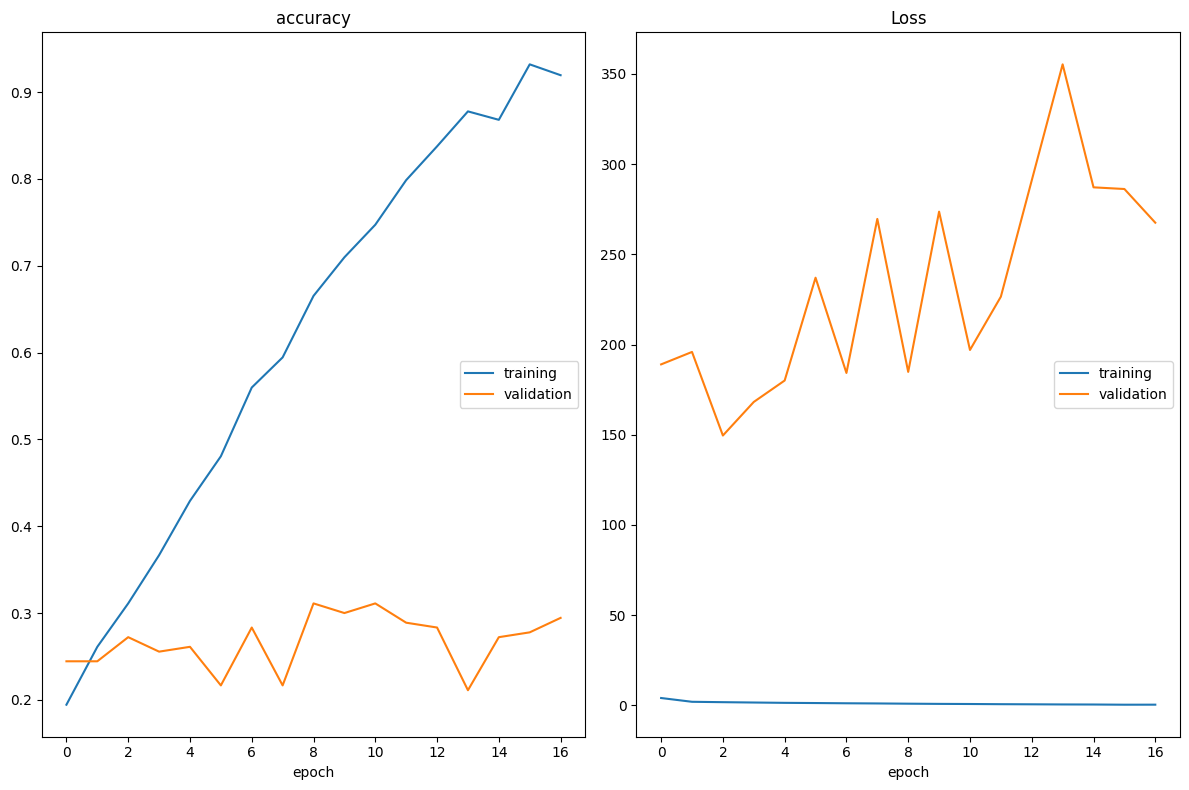

accuracy
	training         	 (min:    0.194, max:    0.932, cur:    0.919)
	validation       	 (min:    0.211, max:    0.311, cur:    0.294)
Loss
	training         	 (min:    0.342, max:    4.048, cur:    0.362)
	validation       	 (min:  149.553, max:  355.296, cur:  267.523)
12/12 [==============================] - 3s 210ms/step - loss: 0.3624 - accuracy: 0.9194 - val_loss: 267.5231 - val_accuracy: 0.2944
saved


In [16]:
import tensorflow as tf
from livelossplot import PlotLossesKeras
if 'vgg_Checkpoints' not in os.listdir(r'../Assignment 3'):
    os.makedirs(r'vgg_Checkpoints/')
checkpoint_filepath = 'vgg_Checkpoints/'
num_of_epochs=100
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model_early_stopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=8,
    verbose=0,
    mode="max",
)

vgg_classification_model_history = vgg_classification_model.fit(train_dataset_classification,
                                                                epochs = num_of_epochs,
                                                                callbacks=[model_checkpoint_callback,model_early_stopping_callback,PlotLossesKeras()],
                                                                validation_data=validation_dataset_classification
                                                                )
# The model weights (that are considered the best) are loaded into the model.
if len(os.listdir(checkpoint_filepath))>0 :
    vgg_classification_model.load_weights(checkpoint_filepath)
vgg_classification_model.save("vgg_calssification_v1.h5")
print('saved')

### Confusion matrix of the network on the training including validation and testing data sets.

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
def calculate_confusion_matrix(model,dataset):
    y_pred=[]
    all_labels=[]
    for batch in dataset :
        data,labels=batch
        y=model.predict(data).argmax(axis=1)
        for l,p in zip(labels.cpu().numpy().argmax(axis=1),y):
            all_labels.append(int(l))
            y_pred.append(int(p))
    ConfusionMatrixDisplay(confusion_matrix(all_labels,y_pred)).plot()
    plt.grid(False)
    plt.show()
    print('Pred',np.unique(y_pred))
    print('labels',np.unique(np.array(all_labels)))
    print(classification_report(all_labels,y_pred))

## Training confusion matrix

1/1 [==============================] - 0s 141ms/step


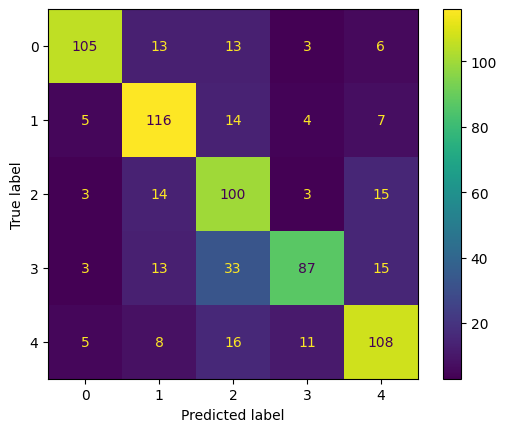

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       140
           1       0.71      0.79      0.75       146
           2       0.57      0.74      0.64       135
           3       0.81      0.58      0.67       151
           4       0.72      0.73      0.72       148

    accuracy                           0.72       720
   macro avg       0.73      0.72      0.72       720
weighted avg       0.73      0.72      0.72       720



In [20]:
calculate_confusion_matrix(vgg_classification_model, train_dataset_classification)

## Validation confusion matrix

2/2 [==============================] - 1s 572ms/step


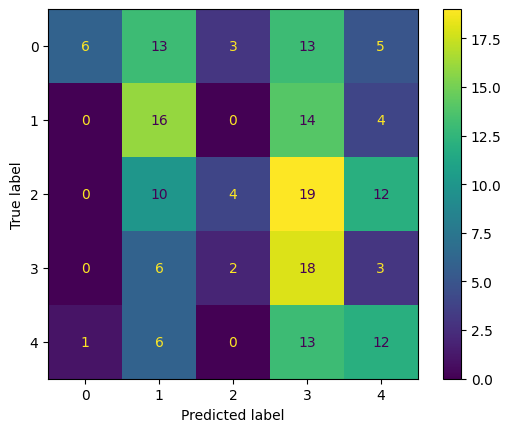

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.86      0.15      0.26        40
           1       0.31      0.47      0.38        34
           2       0.44      0.09      0.15        45
           3       0.23      0.62      0.34        29
           4       0.33      0.38      0.35        32

    accuracy                           0.31       180
   macro avg       0.44      0.34      0.29       180
weighted avg       0.46      0.31      0.28       180



In [21]:
calculate_confusion_matrix(vgg_classification_model, validation_dataset_classification)

## Testing confusion matrix

2/2 [==============================] - 1s 474ms/step


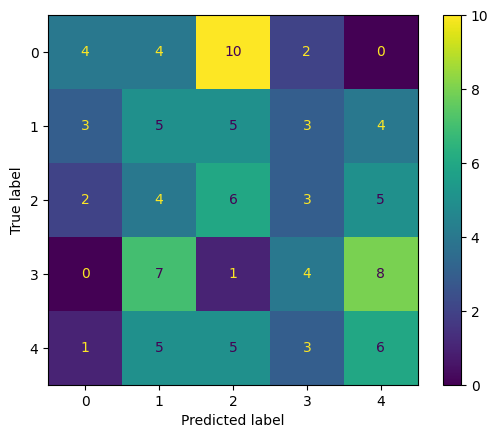

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.40      0.20      0.27        20
           1       0.20      0.25      0.22        20
           2       0.22      0.30      0.26        20
           3       0.27      0.20      0.23        20
           4       0.26      0.30      0.28        20

    accuracy                           0.25       100
   macro avg       0.27      0.25      0.25       100
weighted avg       0.27      0.25      0.25       100



In [22]:
calculate_confusion_matrix(vgg_classification_model, test_dataset_classification)

## Part 1b. Transfer Learning - Regression Reformulation (3 Marks)

### Step 1 (2)
Repeat the steps of Part 1a. but reformulate as a regression problem, i.e., your network needs to output a single float value ranging between 0 to 6 corresponding to the number of leaves. Again, you are not expected to fine-tune the initial VGG layers.

- Plot a loss curve for training and validation data
- Plot an accuracy curve for training and validation data
- Provide confusion matrix of your network on the training including validation and testing data sets.

### Step 2 (1)
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

### Step 1

#### load the dataset and label it as integers with changing the label_mode to int

In [23]:
train_dataset_regression = tf.keras.preprocessing.image_dataset_from_directory(
    directory=training_dir,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed,
    validation_split=0.2,
    subset='training'
)
validation_dataset_regression = tf.keras.preprocessing.image_dataset_from_directory(
    directory=training_dir,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed,
    validation_split=0.2,
    subset='validation'
)
test_dataset_regression = tf.keras.preprocessing.image_dataset_from_directory(
    directory=testing_dir,
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed
)

Found 900 files belonging to 5 classes.
Using 720 files for training.
Found 900 files belonging to 5 classes.
Using 180 files for validation.
Found 100 files belonging to 5 classes.


## Data normalization

In [24]:
train_dataset_regression = train_dataset_regression.map(process)
validation_dataset_regression = validation_dataset_regression.map(process)
test_dataset_regression = test_dataset_regression.map(process)

#### Regression vgg model

In [32]:
from sklearn.metrics import accuracy_score
# run_eagerly=True
def custom_regression_accuracy(y_true, y_pred):
    y_true = y_true.numpy()
    y_true=y_true.astype(np.int64)
    y_pred = y_pred.numpy()
    y_pred=y_pred.reshape(-1)
    for i in range(len (y_pred)) :
        if y_pred[i]>4 :
            y_pred[i]=4
        elif y_pred[i]< 0 :
            y_pred[i]=0
    y_pred=np.round(y_pred).astype(np.int64)
    return accuracy_score(y_pred, y_true)

In [43]:
from keras.applications.vgg16 import VGG16
from keras import Model
from keras import layers
base_vgg_model = VGG16(input_shape = (photo_size, photo_size, 3), include_top = False, weights ='imagenet')
x = layers.Conv2D(64,(3,3))(base_vgg_model.get_layer('block2_pool').output)
x = layers.MaxPool2D((2,2))(x)
x = layers.Conv2D(64,(3,3))(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(1, activation='linear')(x)
vgg_regression_model = Model(base_vgg_model.input, x)
vgg_regression_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss ='mse', metrics =[tf.keras.metrics.MeanSquaredError(),custom_regression_accuracy],run_eagerly=True)
vgg_regression_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

#### Train the vgg regression model

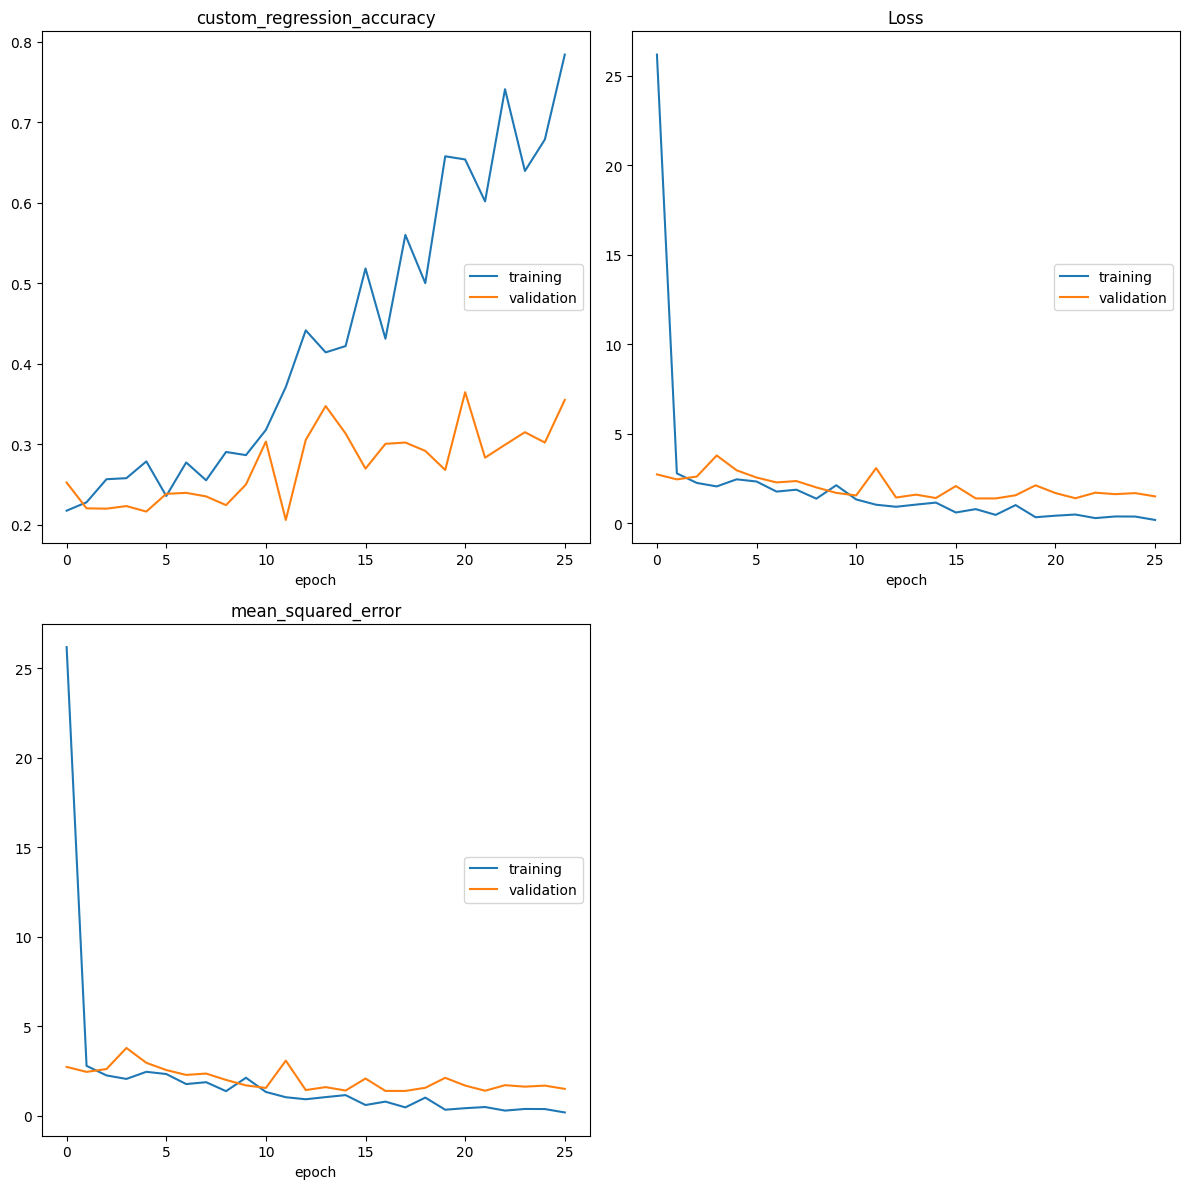

custom_regression_accuracy
	training         	 (min:    0.217, max:    0.784, cur:    0.784)
	validation       	 (min:    0.206, max:    0.365, cur:    0.355)
Loss
	training         	 (min:    0.184, max:   26.176, cur:    0.184)
	validation       	 (min:    1.386, max:    3.785, cur:    1.500)
mean_squared_error
	training         	 (min:    0.184, max:   26.176, cur:    0.184)
	validation       	 (min:    1.386, max:    3.785, cur:    1.500)
12/12 [==============================] - 10s 812ms/step - loss: 0.1837 - mean_squared_error: 0.1837 - custom_regression_accuracy: 0.7839 - val_loss: 1.5001 - val_mean_squared_error: 1.5001 - val_custom_regression_accuracy: 0.3550
saved


In [44]:
import tensorflow as tf
from livelossplot import PlotLossesKeras
if 'vgg_regression_Checkpoints' not in os.listdir(r'../Assignment 3'):
    os.makedirs(r'vgg_regression_Checkpoints/')
checkpoint_filepath = 'vgg_regression_Checkpoints/'
num_of_epochs=100
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)
model_early_stopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_squared_error',
    patience=8,
    verbose=0,
    mode="min",
)

vgg_regression_model_history = vgg_regression_model.fit(train_dataset_regression,
                                                        epochs = num_of_epochs,
                                                        callbacks=[model_checkpoint_callback,model_early_stopping_callback,PlotLossesKeras()],
                                                        validation_data=validation_dataset_regression
                                                        )
# The model weights (that are considered the best) are loaded into the model.
if len(os.listdir(checkpoint_filepath))>0 :
    vgg_regression_model.load_weights(checkpoint_filepath)
vgg_regression_model.save("vgg_regression_v1.h5")
print('saved')

**We saved the model which gives us the least mean square on the validation data**

#### Function to calculate the confusion matrix with respect to the regression

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report
def calculate_confusion_matrix_regression(model,dataset):
    y_pred=[]
    all_labels=[]
    for batch in dataset :
        data,labels=batch
        y=model.predict(data)
        y=y.reshape(-1)
        for i in range(len (y)) :
            if y[i]>4 :
                y[i]=4
            elif y[i]<0 :
                y[i]=0
        y=np.round(y).astype(np.int64)
        for l,p in zip(labels.cpu().numpy(),y):
            all_labels.append(int(l))
            y_pred.append(int(p))
        # print(all_labels)
    ConfusionMatrixDisplay(confusion_matrix(all_labels,y_pred)).plot()
    plt.grid(False)
    plt.show()
    print(classification_report(all_labels,y_pred))


## Training confusion matrix in regression

1/1 [==============================] - 0s 47ms/step


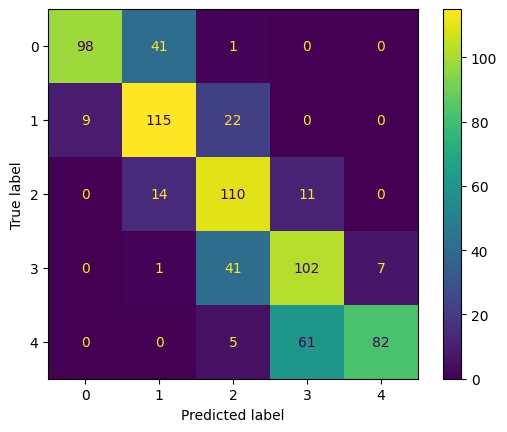

              precision    recall  f1-score   support

           0       0.92      0.70      0.79       140
           1       0.67      0.79      0.73       146
           2       0.61      0.81      0.70       135
           3       0.59      0.68      0.63       151
           4       0.92      0.55      0.69       148

    accuracy                           0.70       720
   macro avg       0.74      0.71      0.71       720
weighted avg       0.74      0.70      0.71       720



In [46]:
calculate_confusion_matrix_regression(vgg_regression_model, train_dataset_regression)

## Validation confusion matrix in regression

2/2 [==============================] - 1s 538ms/step


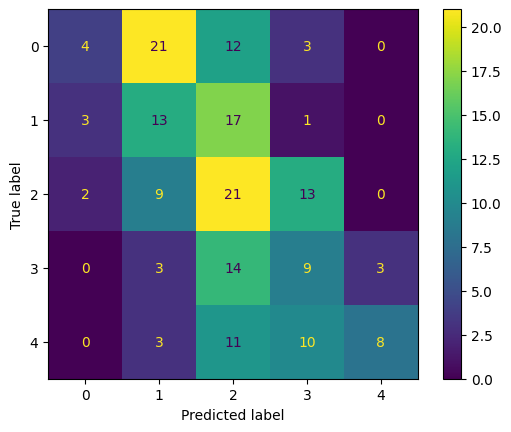

              precision    recall  f1-score   support

           0       0.44      0.10      0.16        40
           1       0.27      0.38      0.31        34
           2       0.28      0.47      0.35        45
           3       0.25      0.31      0.28        29
           4       0.73      0.25      0.37        32

    accuracy                           0.31       180
   macro avg       0.39      0.30      0.30       180
weighted avg       0.39      0.31      0.29       180



In [48]:
calculate_confusion_matrix_regression(vgg_regression_model, validation_dataset_regression)

## Testing confusion matrix in regression

2/2 [==============================] - 0s 92ms/step


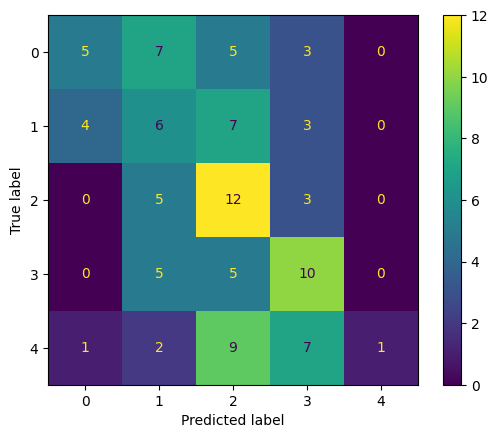

              precision    recall  f1-score   support

           0       0.50      0.25      0.33        20
           1       0.24      0.30      0.27        20
           2       0.32      0.60      0.41        20
           3       0.38      0.50      0.43        20
           4       1.00      0.05      0.10        20

    accuracy                           0.34       100
   macro avg       0.49      0.34      0.31       100
weighted avg       0.49      0.34      0.31       100



In [49]:
calculate_confusion_matrix_regression(vgg_regression_model, test_dataset_regression)

## Step 2
The size of the training data is quite small. Discuss based on your learning curves if overfitting is occurring with the models from Parts 1a and 1b.

From **part 1a the classification problem**
Training accuracy is 72% and testing accuracy is 25%
**So, it's an overfitting**and the model can't generalize through the testing data and this may be because the small dataset and the model architecture.


From **part 1b the regression problem**
Training accuracy is 70% and testing accuracy is 31%
it is also **an overfitting** and it is better than the classification architecture.

## Part 2. Improve your Model (4 Marks)

Regularization and data augmentation are common strategies to deal with small datasets.

### Step 1 (1.5)
Incorporate Batch Normalization and Dropout into your design the superior network trained in Part 1. You are not expected to fine-tune the initial VGG layers. Again you will provide the following:
- A loss curve for training and validation data
- An accuracy curve for training and validation data
- A confusion matrix of your network on the training including validation and testing data sets.
 

### Step 2 (1.5)
Train the same model from Step 1, now using data augmentation. Again, please provide the same output metrics as in Step 1.

### Step 3 (1)
Discuss based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

## Step 1
Adding regularization and batch normalization to the model architecture

In [80]:
# Write your code here
# Write your code here
from keras.applications.vgg16 import VGG16
from keras import Model
from keras import layers
base_vgg_model = VGG16(input_shape = (photo_size, photo_size, 3), include_top = False, weights ='imagenet')
x = layers.Conv2D(64,(3,3))(base_vgg_model.get_layer('block2_pool').output)
x = layers.MaxPool2D((2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(64,(3,3))(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(os.listdir(training_dir)), activation='softmax')(x)
vgg_classification_model_with_regularization = Model(base_vgg_model.input, x)
vgg_classification_model_with_regularization.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss ='categorical_crossentropy', metrics = ['accuracy'])
vgg_classification_model_with_regularization.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

#### Training and curve losses and accuracies curves plotting

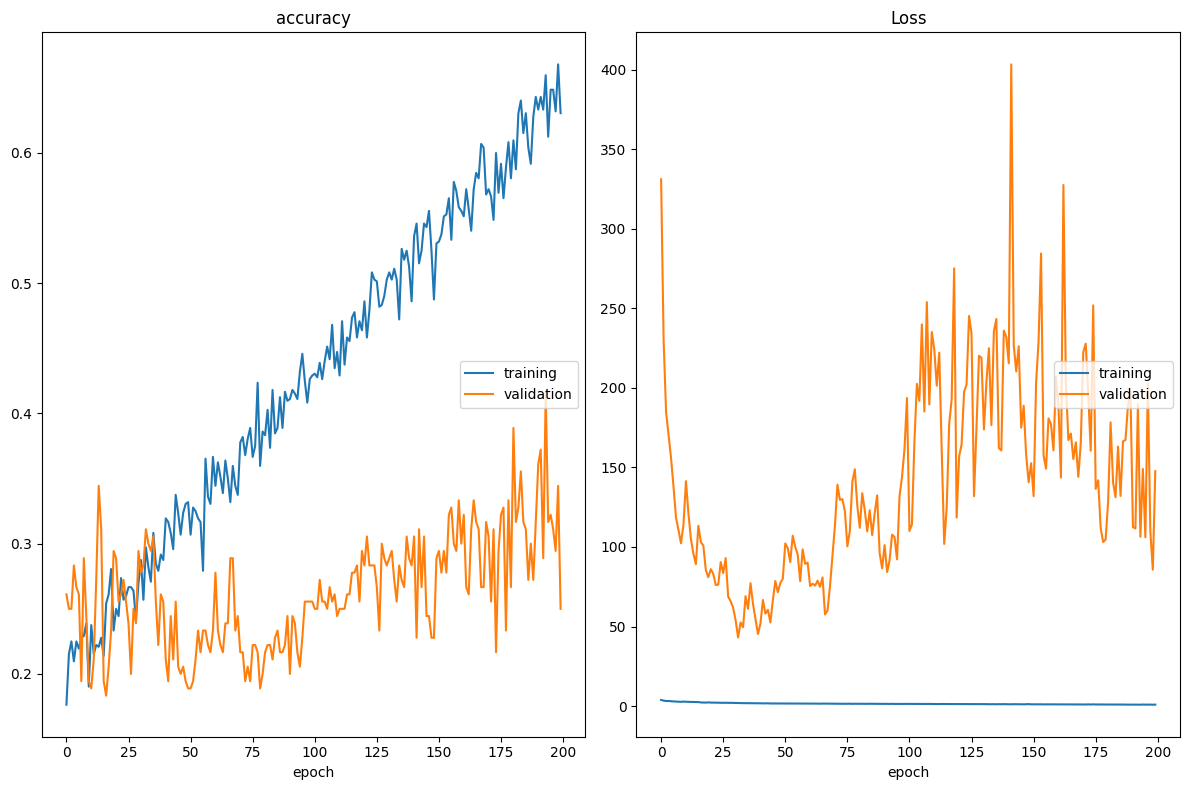

accuracy
	training         	 (min:    0.176, max:    0.668, cur:    0.631)
	validation       	 (min:    0.183, max:    0.417, cur:    0.250)
Loss
	training         	 (min:    0.858, max:    3.860, cur:    0.909)
	validation       	 (min:   43.136, max:  403.283, cur:  147.649)
12/12 [==============================] - 7s 493ms/step - loss: 0.9091 - accuracy: 0.6306 - val_loss: 147.6487 - val_accuracy: 0.2500
saved


In [81]:
import tensorflow as tf
from livelossplot import PlotLossesKeras
if 'vgg_Checkpoints_regularization' not in os.listdir(r'../Assignment 3'):
    os.makedirs(r'vgg_Checkpoints_regularization/')
checkpoint_filepath = 'vgg_Checkpoints_regularization/'
num_of_epochs=200
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
# model_early_stopping_callback=tf.keras.callbacks.EarlyStopping(
#     monitor="val_accuracy",
#     patience=15,
#     verbose=0,
#     mode="max",
# )
vgg_classification_model_with_regularization_history = vgg_classification_model_with_regularization.fit(train_dataset_classification,
                                                                epochs = num_of_epochs,
                                                                callbacks=[model_checkpoint_callback,
                                                                           # model_early_stopping_callback,
                                                                           PlotLossesKeras()],
                                                                validation_data=validation_dataset_classification
                                                                )
# The model weights (that are considered the best) are loaded into the model.
if len(os.listdir(checkpoint_filepath))>0 :
    vgg_classification_model_with_regularization.load_weights(checkpoint_filepath)
vgg_classification_model_with_regularization.save("vgg_classification_model_with_regularization.h5")
print('saved')

#### Training confusion matrix in regression with augmentation

1/1 [==============================] - 0s 146ms/step


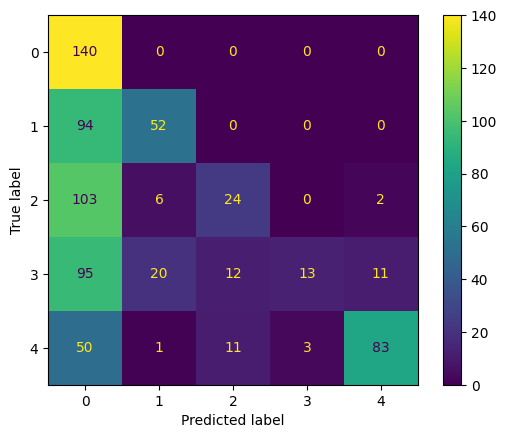

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.29      1.00      0.45       140
           1       0.66      0.36      0.46       146
           2       0.51      0.18      0.26       135
           3       0.81      0.09      0.16       151
           4       0.86      0.56      0.68       148

    accuracy                           0.43       720
   macro avg       0.63      0.44      0.40       720
weighted avg       0.63      0.43      0.40       720



In [82]:
calculate_confusion_matrix(vgg_classification_model_with_regularization, train_dataset_classification)

#### Validation confusion matrix in regression with augmentation

2/2 [==============================] - 0s 57ms/step


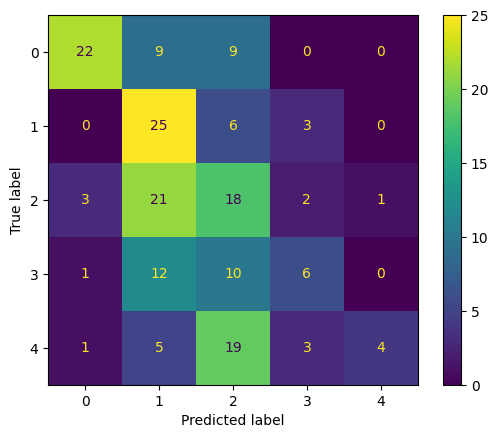

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.81      0.55      0.66        40
           1       0.35      0.74      0.47        34
           2       0.29      0.40      0.34        45
           3       0.43      0.21      0.28        29
           4       0.80      0.12      0.22        32

    accuracy                           0.42       180
   macro avg       0.54      0.40      0.39       180
weighted avg       0.53      0.42      0.40       180



In [83]:
calculate_confusion_matrix(vgg_classification_model_with_regularization, validation_dataset_classification)

#### Testing confusion matrix in regression with augmentation

2/2 [==============================] - 0s 63ms/step


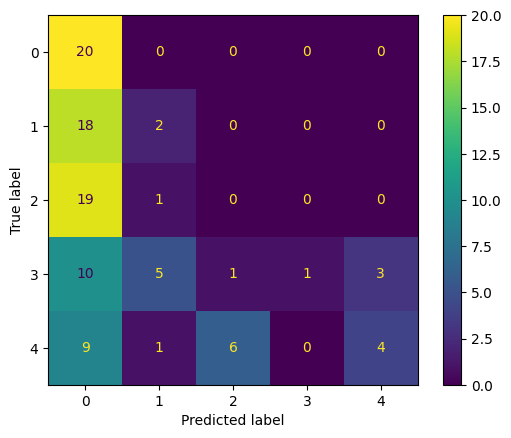

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.26      1.00      0.42        20
           1       0.22      0.10      0.14        20
           2       0.00      0.00      0.00        20
           3       1.00      0.05      0.10        20
           4       0.57      0.20      0.30        20

    accuracy                           0.27       100
   macro avg       0.41      0.27      0.19       100
weighted avg       0.41      0.27      0.19       100



In [84]:
calculate_confusion_matrix(vgg_classification_model_with_regularization, test_dataset_classification)

## Step 2 Data Augmentation
Here, I will use image data generator to generate image and save them with their classes in the dataset
This data generation techniques tries to generate variations of the original data such as rotate the original images a little, shift in height, shift in width ,
horizontal flip and random zoom in.

#### Check the number of images in each class before augmentation

In [71]:
path='training'
for folder in os.listdir(path):
    in_path=os.path.join(path,folder)
    number_of_images=len(os.listdir(in_path))
    print(number_of_images)

180
180
180
180
180


In [72]:
import os
from keras.utils import load_img,img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.1,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.1,
    )
for folder in os.listdir(path):
    in_path=os.path.join(path,folder)
    number_of_images=len(os.listdir(in_path))
    arr=[]
    for image in os.listdir(in_path) :
        image_path=os.path.join(in_path,image)
        arr.append(img_to_array(load_img(image_path,target_size=(photo_size,photo_size))))
    arr=np.array(arr)
    datagen.fit(arr,augment=True)
    it = datagen.flow(arr, batch_size=number_of_images,save_to_dir=in_path)
    for i in range(int(1000/number_of_images)):
        batch = it.next()

#### Check the number of images in each class after augmentation

In [96]:
for folder in os.listdir(path):
    in_path=os.path.join(path,folder)
    number_of_images=len(os.listdir(in_path))
    print(number_of_images)

1080
1080
1079
1080
1080


In [97]:
train_dataset_classification_augmented = tf.keras.preprocessing.image_dataset_from_directory(
    directory=training_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed,
    subset='training',
    validation_split=0.2
)
validation_dataset_classification_augmented = tf.keras.preprocessing.image_dataset_from_directory(
    directory=training_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed,
    subset='validation',
    validation_split=0.2
)
test_dataset_classification_augmented = tf.keras.preprocessing.image_dataset_from_directory(
    directory=testing_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed
)

Found 5399 files belonging to 5 classes.
Using 4320 files for training.
Found 5399 files belonging to 5 classes.
Using 1079 files for validation.
Found 100 files belonging to 5 classes.


In [98]:
train_dataset_classification_augmented=train_dataset_classification_augmented.map(process)
validation_dataset_classification_augmented=validation_dataset_classification_augmented.map(process)
test_dataset_classification_augmented=test_dataset_classification_augmented.map(process)

#### Training the model with the new data after augmentation

In [99]:
# Write your code here
# Write your code here
from keras.applications.vgg16 import VGG16
from keras import Model
from keras import layers
base_vgg_model = VGG16(input_shape = (photo_size, photo_size, 3), include_top = False, weights ='imagenet')
x = layers.Conv2D(64,(3,3))(base_vgg_model.get_layer('block2_pool').output)
x = layers.MaxPool2D((2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(64,(3,3))(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(os.listdir(training_dir)), activation='softmax')(x)
vgg_classification_model_with_regularization_after_augmentation = Model(base_vgg_model.input, x)
vgg_classification_model_with_regularization_after_augmentation.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss ='categorical_crossentropy', metrics = ['accuracy'])
vgg_classification_model_with_regularization_after_augmentation.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

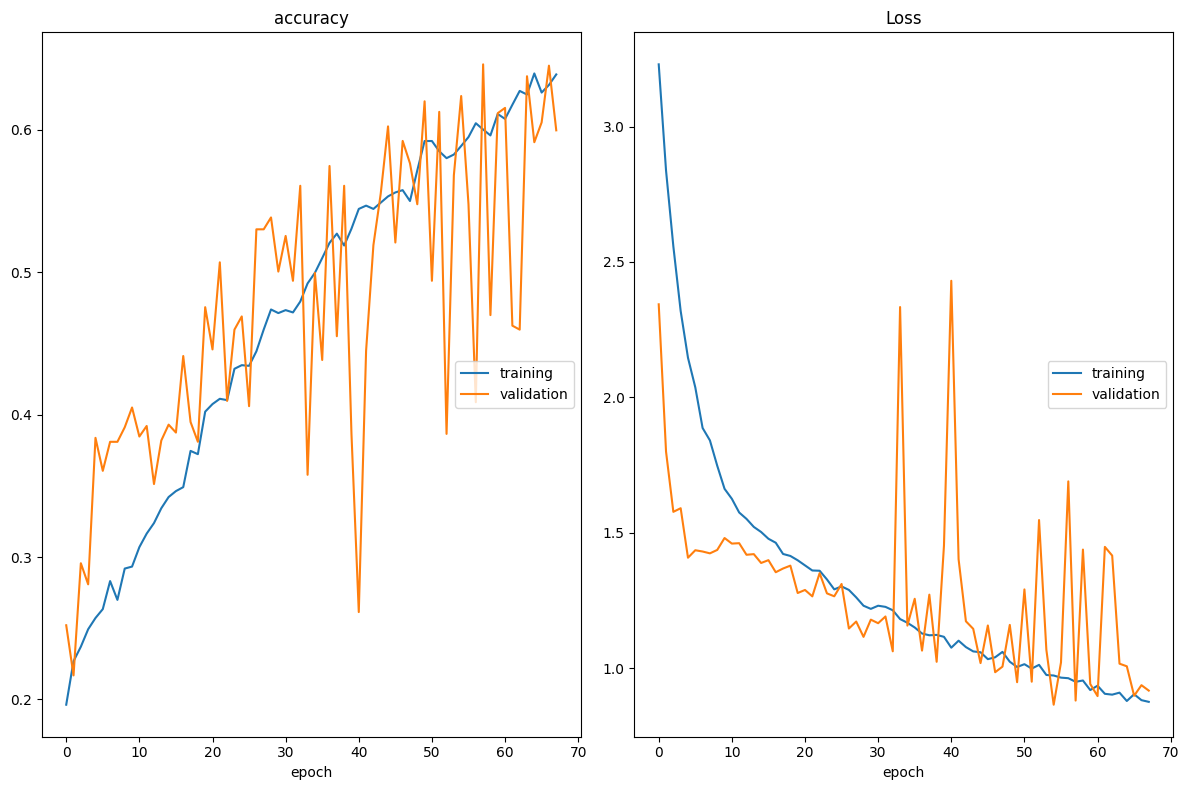

accuracy
	training         	 (min:    0.196, max:    0.640, cur:    0.639)
	validation       	 (min:    0.217, max:    0.646, cur:    0.600)
Loss
	training         	 (min:    0.876, max:    3.230, cur:    0.876)
	validation       	 (min:    0.866, max:    2.431, cur:    0.918)
68/68 [==============================] - 33s 474ms/step - loss: 0.8763 - accuracy: 0.6389 - val_loss: 0.9179 - val_accuracy: 0.5996
saved


In [100]:
import tensorflow as tf
from livelossplot import PlotLossesKeras
if 'vgg_Checkpoints_regularization' not in os.listdir(r'../Assignment 3'):
    os.makedirs(r'vgg_Checkpoints_regularization/')
checkpoint_filepath = 'vgg_Checkpoints_regularization/'
num_of_epochs=100
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model_early_stopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    verbose=0,
    mode="max",
)
vgg_classification_model_with_regularization_after_augmentation_history = vgg_classification_model_with_regularization_after_augmentation.fit(train_dataset_classification_augmented,
                                                                epochs = num_of_epochs,
                                                                callbacks=[model_checkpoint_callback,model_early_stopping_callback,PlotLossesKeras()],
                                                                validation_data=validation_dataset_classification_augmented
                                                                )
# The model weights (that are considered the best) are loaded into the model.
if len(os.listdir(checkpoint_filepath))>0 :
    vgg_classification_model_with_regularization_after_augmentation.load_weights(checkpoint_filepath)
vgg_classification_model_with_regularization_after_augmentation.save("vgg_classification_model_with_regularization_after_augmentation.h5")
print('saved')

## Traning Confusion matrix after augmentation and regularization

1/1 [==============================] - 0s 46ms/step


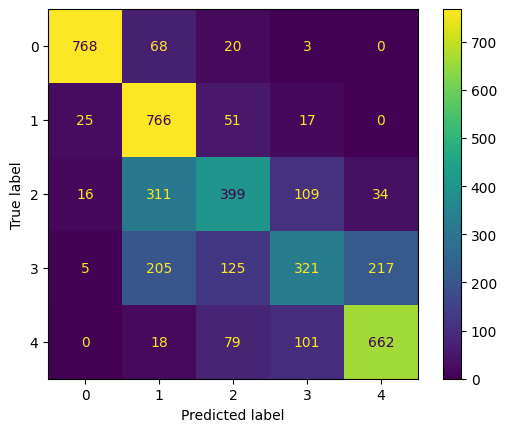

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       859
           1       0.56      0.89      0.69       859
           2       0.59      0.46      0.52       869
           3       0.58      0.37      0.45       873
           4       0.73      0.77      0.75       860

    accuracy                           0.68      4320
   macro avg       0.68      0.68      0.66      4320
weighted avg       0.68      0.68      0.66      4320



In [110]:
calculate_confusion_matrix(vgg_classification_model_with_regularization_after_augmentation,train_dataset_classification_augmented)

## Validation Confusion matrix after augmentation and regularization

2/2 [==============================] - 1s 1s/step


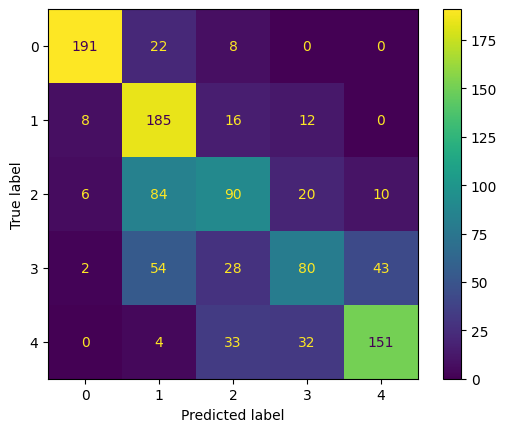

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       221
           1       0.53      0.84      0.65       221
           2       0.51      0.43      0.47       210
           3       0.56      0.39      0.46       207
           4       0.74      0.69      0.71       220

    accuracy                           0.65      1079
   macro avg       0.65      0.64      0.64      1079
weighted avg       0.66      0.65      0.64      1079



In [111]:
calculate_confusion_matrix(vgg_classification_model_with_regularization_after_augmentation,validation_dataset_classification_augmented)

## Testing Confusion matrix after augmentation and regularization

2/2 [==============================] - 0s 60ms/step


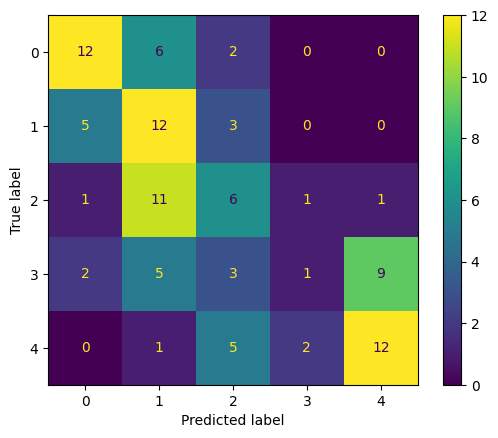

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        20
           1       0.34      0.60      0.44        20
           2       0.32      0.30      0.31        20
           3       0.25      0.05      0.08        20
           4       0.55      0.60      0.57        20

    accuracy                           0.43       100
   macro avg       0.41      0.43      0.40       100
weighted avg       0.41      0.43      0.40       100



In [112]:
calculate_confusion_matrix(vgg_classification_model_with_regularization_after_augmentation,test_dataset_classification_augmented)

## Preprocessing
According to the problem of detecting the number of leaves so the colors not important to differentiate between the classes, so I will convert the dataset to gray scale and try to segment only the planet and remove the background.

In [101]:
import shutil
import cv2
def select_the_green_color(image):
    """Detect only the green color from the image"""
    low_green = np.array([10, 40, 170])
    high_green = np.array([50, 100, 255])
    height, width, channels = image.shape
    image = cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC)
    # convert BGR to HSV
    image_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # create the Mask
    mask = cv2.inRange(image_HSV, low_green, high_green)
    # inverse mask
    # mask = 255-mask
    res = cv2.bitwise_and(image, image, mask=mask)
    return res

def convert_2_binary(image):
    """Convert it to a binary image with specific threshold"""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, )
    blurred = cv2.GaussianBlur(gray_image, (7, 7), 0)
    threshold_k, binary_image = cv2.threshold(blurred, 130, 255, cv2.THRESH_BINARY_INV)
    # binary_image =cv2.adaptiveThreshold(blurred, 150,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 21, 10)
    return binary_image


def sharp_the_image(image):
    """Image sharpness"""
    sharpen_filter = np.array([[-1, -1, -1],
                               [-1, 9, -1],
                               [-1, -1, -1]])
    sharpen_image = cv2.filter2D(image, -1, sharpen_filter)
    return sharpen_image


def image_pipeline(image):
    """Image pipeline to get the sharpen_field"""
    image_copy = image.copy()
    # img = select_the_green_color(image_copy)
    img = convert_2_binary(image_copy)
    img = sharp_the_image(img)
    return img


def preprocessing(data_dir, new_dir):
    # Create the same folders in the distenation
    if len(os.listdir(new_dir)) == 0:
        for folder in os.listdir(data_dir):
            os.makedirs(os.path.join(new_dir, folder))
    for folder in os.listdir(data_dir):
        images_path = os.path.join(data_dir, folder)
        for image in os.listdir(images_path):
            image_path = os.path.join(images_path, image)
            img = cv2.imread(image_path)
            #Preprocessing
            preprocessed_image = image_pipeline(img)
            # Save the preprocessed image to the new destenation
            cv2.imwrite(os.path.join(new_dir, folder, image), preprocessed_image)

preprocessing(training_dir, 'EnhancedDataset/training/')
preprocessing(testing_dir, 'EnhancedDataset/testing/')

## Visualization of the preprocessed data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


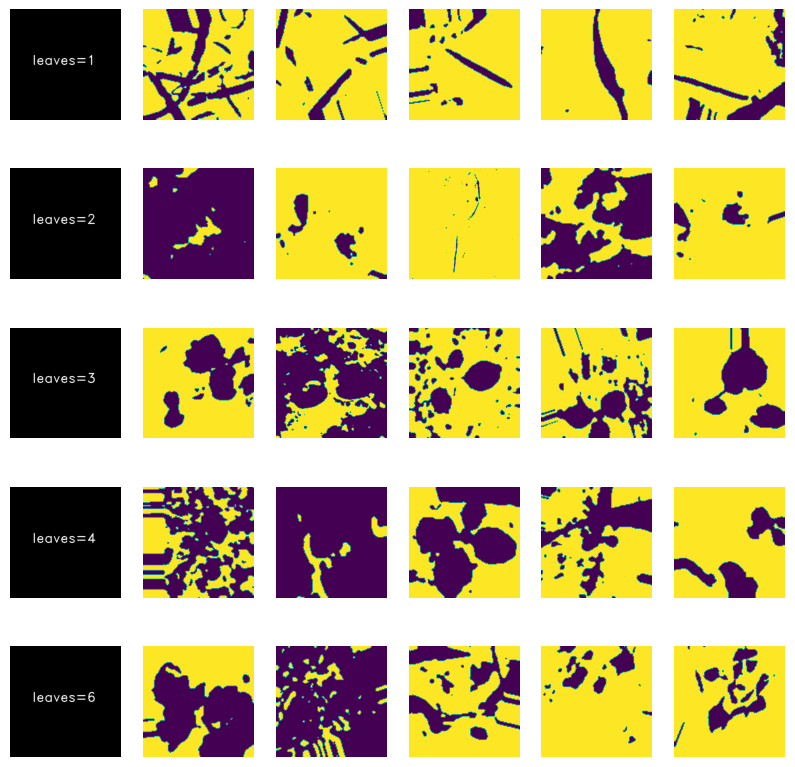

In [102]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
# Prepare your dataset here
training_dir='training'
testing_dir='testing'
vis_images=[]
n_image_vis=5
for folder in os.listdir('EnhancedDataset/training'):
    inner_path=os.path.join('EnhancedDataset/training',folder)
    samples=random.sample(os.listdir(inner_path),k=n_image_vis)
    name_image=np.zeros((500,500,3))
    r,g,b = cv2.split(name_image)
    img_bgr = cv2.merge([b,g,r])
    cv2.putText(img_bgr,text=f'leaves={folder}',org=(100,250),fontFace=cv2.QT_FONT_NORMAL,fontScale=2,color=(255,255,255),thickness=2)
    vis_images.append(img_bgr)
    for image in samples:
        img=Image.open(os.path.join(inner_path,image))
        img=img.resize((500,500))
        vis_images.append(img)
n_row,n_col=(len(os.listdir(training_dir)),n_image_vis+1)
_, axs = plt.subplots(n_row, n_col, figsize=(10, 10))
axs = axs.flatten()
for img, ax in zip(vis_images, axs):
    ax.imshow(img)
    ax.grid(False)
    ax.axis(False)


In [103]:
train_preprocessing_augmented_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='EnhancedDataset/training/',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed,
    subset='training',
    validation_split=0.2
)
validation_preprocessing_augmented_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='EnhancedDataset/training/',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed,
    subset='validation',
    validation_split=0.2
)
test_preprocessing_augmented_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='EnhancedDataset/testing/',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=(photo_size, photo_size),
    seed=seed
)

Found 5399 files belonging to 5 classes.
Using 4320 files for training.
Found 5399 files belonging to 5 classes.
Using 1079 files for validation.
Found 100 files belonging to 5 classes.


## Data normalization

In [104]:
train_preprocessing_augmented_dataset=train_preprocessing_augmented_dataset.map(process)
validation_preprocessing_augmented_dataset=validation_preprocessing_augmented_dataset.map(process)
test_preprocessing_augmented_dataset=test_preprocessing_augmented_dataset.map(process)

In [108]:
# Write your code here
# Write your code here
from keras.applications.vgg16 import VGG16
from keras import Model
from keras import layers
base_vgg_model = VGG16(input_shape = (photo_size, photo_size, 3), include_top = False, weights ='imagenet')
x = layers.Conv2D(64,(3,3))(base_vgg_model.get_layer('block2_pool').output)
x = layers.MaxPool2D((2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(64,(3,3))(x)
x = layers.MaxPool2D((2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(len(os.listdir(training_dir)), activation='softmax')(x)
vgg_classification_model_with_regularization_preprocessing = Model(base_vgg_model.input, x)
vgg_classification_model_with_regularization_preprocessing.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss ='categorical_crossentropy', metrics = ['accuracy'])
vgg_classification_model_with_regularization_preprocessing.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0  

### Train the model with the preprocessing data

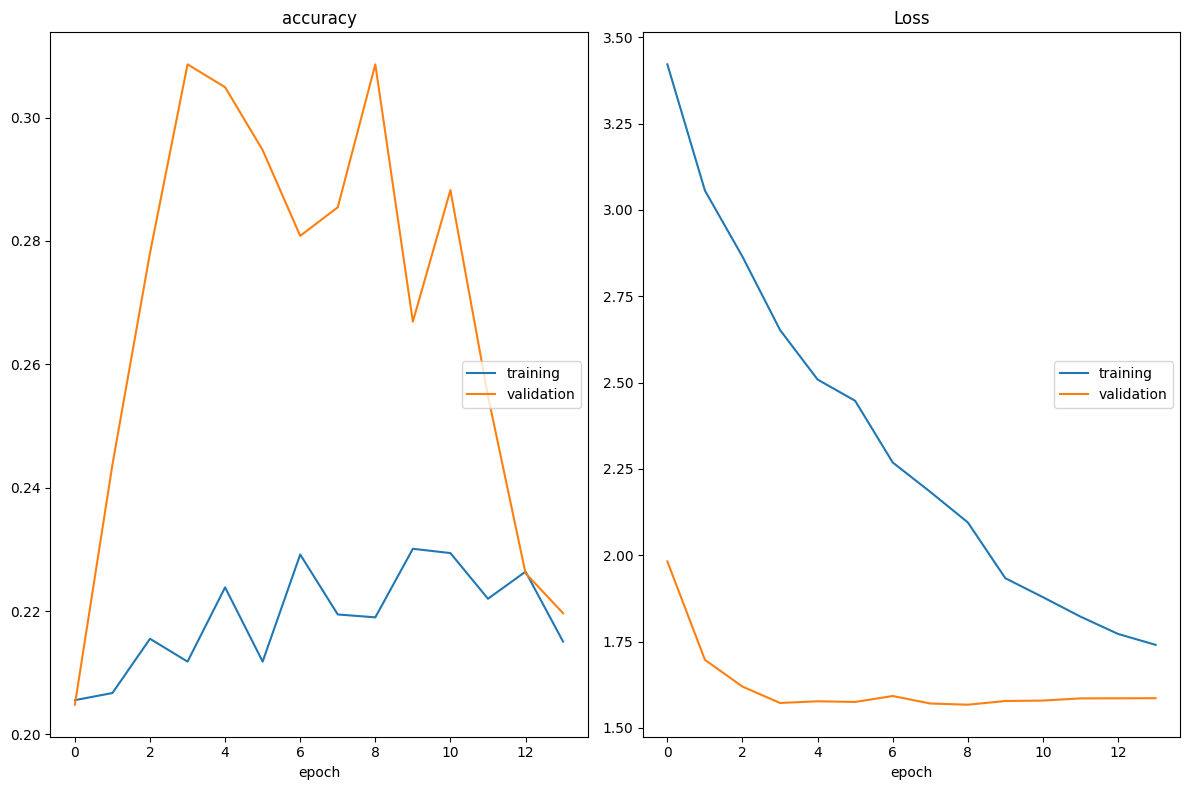

accuracy
	training         	 (min:    0.206, max:    0.230, cur:    0.215)
	validation       	 (min:    0.205, max:    0.309, cur:    0.220)
Loss
	training         	 (min:    1.741, max:    3.422, cur:    1.741)
	validation       	 (min:    1.567, max:    1.982, cur:    1.586)
68/68 [==============================] - 37s 538ms/step - loss: 1.7407 - accuracy: 0.2150 - val_loss: 1.5863 - val_accuracy: 0.2196
saved


In [109]:
import tensorflow as tf
from livelossplot import PlotLossesKeras
if 'vgg_Checkpoints_regularization' not in os.listdir(r'../Assignment 3'):
    os.makedirs(r'vgg_Checkpoints_regularization/')
checkpoint_filepath = 'vgg_Checkpoints_regularization/'
num_of_epochs=100
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model_early_stopping_callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    verbose=0,
    mode="max",
)
vgg_classification_model_with_regularization_preprocessing_history = vgg_classification_model_with_regularization_preprocessing.fit(train_preprocessing_augmented_dataset,
                                                                                                        epochs = num_of_epochs,
                                                                                                        callbacks=[model_checkpoint_callback,model_early_stopping_callback,PlotLossesKeras()],
                                                                                                        validation_data=validation_preprocessing_augmented_dataset
                                                                                                        )
# The model weights (that are considered the best) are loaded into the model.
if len(os.listdir(checkpoint_filepath))>0 :
    vgg_classification_model_with_regularization_preprocessing.load_weights(checkpoint_filepath)
vgg_classification_model_with_regularization_preprocessing.save("vgg_classification_model_with_regularization_after_augmentation.h5")
print('saved')

## Training Confusion matrix with augmentation and preprocessing

1/1 [==============================] - 0s 49ms/step


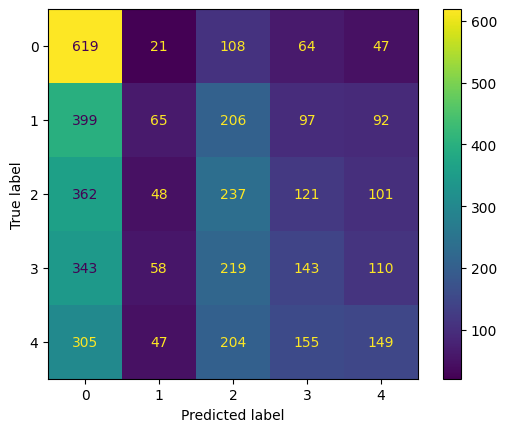

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.31      0.72      0.43       859
           1       0.27      0.08      0.12       859
           2       0.24      0.27      0.26       869
           3       0.25      0.16      0.20       873
           4       0.30      0.17      0.22       860

    accuracy                           0.28      4320
   macro avg       0.27      0.28      0.24      4320
weighted avg       0.27      0.28      0.24      4320



In [113]:
calculate_confusion_matrix(vgg_classification_model_with_regularization_preprocessing,train_preprocessing_augmented_dataset)

## Validation Confusion matrix with augmentation and preprocessing

2/2 [==============================] - 0s 254ms/step


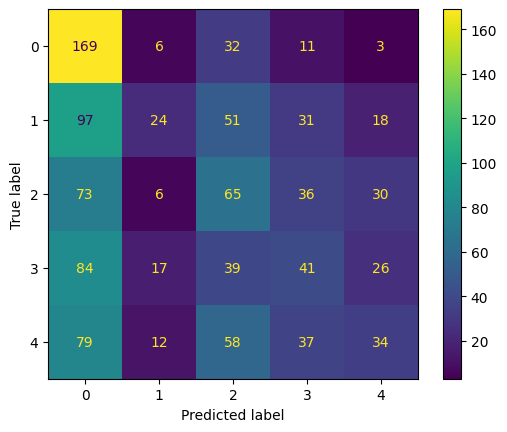

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.34      0.76      0.47       221
           1       0.37      0.11      0.17       221
           2       0.27      0.31      0.29       210
           3       0.26      0.20      0.23       207
           4       0.31      0.15      0.21       220

    accuracy                           0.31      1079
   macro avg       0.31      0.31      0.27      1079
weighted avg       0.31      0.31      0.27      1079



In [114]:
calculate_confusion_matrix(vgg_classification_model_with_regularization_preprocessing,validation_preprocessing_augmented_dataset)

## Testing Confusion matrix with augmentation and preprocessing

1/1 [==============================] - 0s 47ms/step


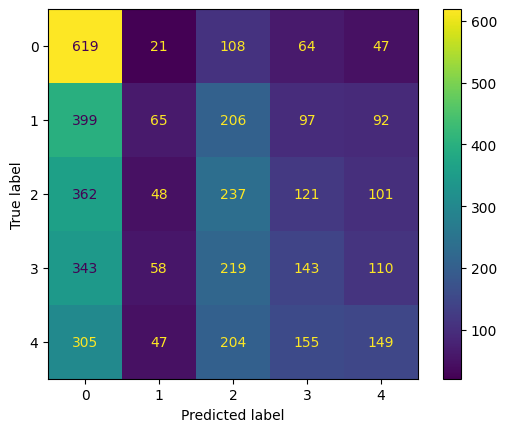

Pred [0 1 2 3 4]
labels [0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.31      0.72      0.43       859
           1       0.27      0.08      0.12       859
           2       0.24      0.27      0.26       869
           3       0.25      0.16      0.20       873
           4       0.30      0.17      0.22       860

    accuracy                           0.28      4320
   macro avg       0.27      0.28      0.24      4320
weighted avg       0.27      0.28      0.24      4320



In [115]:
calculate_confusion_matrix(vgg_classification_model_with_regularization_preprocessing,train_preprocessing_augmented_dataset)

### Step 3 Discussion
based on your learning curves and final metrics in Step 2, how large a improvement can be observed from regularization and data augmentation.

### From the previous graph results:
#### Regularization and batch normalization :
Regularization using dropout and batch normalization layers decrease the overfitting **from** 72 % train and 25% test **to** 60% train and 41% test and the early stopping technique chose the best one which achieves **42% on the test data**.
#### Data augmentation with the regularization techniques
This data generation techniques tries to generate variations of the original data such as rotate the original images a little, shift in height, shift in width ,
horizontal flip and random zoom in.
After this augmentation the dataset size increased and this gives the model a good effect in the performance.
After training the model with this new augmented dataset From the results the model **overcome overfitting between traning and validation and achieves 68% on the training and 65% in the validation but the model filas to generalize on the testing data and get accuracy(43%)**,but this model is the best one between all the models we tried.
#### Perform some preprocessing on this augmented data
According to the problem of detecting the number of leaves so the colors not important to differentiate between the classes, so I will convert the dataset to gray scale and try to segment only the planet and remove the background.
The results of this preprocessing wasn't good and didn't achieve any progress and this because the segmentation tequnique didn't generalize,so some images wasn't good.



## References
[1] N. Teimouri, M. Dyrmann, P. R. Nielsen, S. K. Mathiassen, G. J. Somerville, and R. N. Jørgensen, “Weed growth stage estimator using deep convolutional neural networks,” Sensors, vol. 18, no. 5, 2018.